# **DATALOADING**

In [1]:
#####################################################
################## PACKAGES #########################
#####################################################
import pandas as pd
import sys 
import base64
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import random
from sklearn.metrics import accuracy_score, roc_auc_score
from datetime import datetime, timedelta, date
from itertools import combinations
from numpy.linalg import norm
import pickle
import os
import torch.nn as nn
import torch
from torch.nn import Linear
import torch.nn.functional as F
import altair as alt
from altair import expr, datum
from vega_datasets import data
from geopy.geocoders import Nominatim
from tqdm import tqdm
import os
import random
import shutil
import time

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

In [2]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from utils import *

tqdm.pandas()
DATA_PATH = '/content/drive/MyDrive/hackathon QB/data'

In [4]:
import os
import random
import shutil
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets


def split_total_images_folder(DATA_PATH, split_ratio=0.8):
    """Create two folders for train and validation set

    Args:
        DATA_PATH (str): the data path
        split_ratio (float between 0 and 1): the split ratio between train and val
    """

    # Define the paths
    original_folder = f'{DATA_PATH}/images'
    train_folder = f'{DATA_PATH}/train_images'
    val_folder = f'{DATA_PATH}/val_images'

    # Check if the split has already been done
    if os.path.exists(train_folder) and os.path.exists(val_folder):
        print("Split has already been done. Exiting...")

    else:
        # Create the train and validation folders
        os.makedirs(train_folder, exist_ok=True)
        os.makedirs(val_folder, exist_ok=True)

        # Define the split ratio (80% for training, 20% for validation)
        

        # Walk through the original folder and copy images to train and validation folders
        for root, dirs, files in os.walk(original_folder):
            for subdir in dirs:
                original_subfolder = os.path.join(root, subdir)
                train_subfolder = os.path.join(train_folder, subdir)
                val_subfolder = os.path.join(val_folder, subdir)

                os.makedirs(train_subfolder, exist_ok=True)
                os.makedirs(val_subfolder, exist_ok=True)

                images = os.listdir(original_subfolder)
                random.shuffle(images)

                split_index = int(len(images) * split_ratio)
                train_images = images[:split_index]
                val_images = images[split_index:]

                for image in train_images:
                    src = os.path.join(original_subfolder, image)
                    dst = os.path.join(train_subfolder, image)
                    shutil.copyfile(src, dst)

                for image in val_images:
                    src = os.path.join(original_subfolder, image)
                    dst = os.path.join(val_subfolder, image)
                    shutil.copyfile(src, dst)

        print("Split completed successfully.")

In [5]:
split_total_images_folder(DATA_PATH)

Split has already been done. Exiting...


# **DATA AUGMENTATION-PREPROCESS**

In [23]:
# Set the paths to the training and validation data
train_data_dir = '/content/drive/MyDrive/hackathon QB/data/train_images'
valid_data_dir = '/content/drive/MyDrive/hackathon QB/data/val_images'

# Set the image size, batch size, and number of epochs
img_size = (64, 64)
batch_size = 32
epochs = 20

# Data augmentation to increase the diversity of the training data
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=img_size),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize(size=img_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_data_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_data_dir, transform=valid_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# **RESNET50 PRE-TRAINED**

In [24]:
labels_map = {
    0: "no_plume",
    1: "plume"
}
#num classes
num_classes = 2

In [25]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), 
    nn.Softmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
resnet50 = resnet50.to('cpu')

# Define Optimizer and Loss Function
loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters())

In [26]:
def train(model, epochs, loss_criterion, train_loader, valid_loader, device, model_name, performances_df=None):
    
    if performances_df == None:
        performances_df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss', 'train_accu', 'val_accu', 'train_auc', 'val_auc'])
    
    best_loss = np.inf
    
    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        # Set to training mode
        resnet50.train()
        # Loss and Accuracy within the epoch
        train_loss = []
        train_accu = []
        train_auc = []

        val_loss = []
        val_accu = []
        val_auc = []

        for i, (inputs, labels) in enumerate(train_loader):
            ################
            ###  TRAIN   ###
            ################
            inputs = inputs.to(device)
            labels = labels.to(device)
            numpy_labels = labels.cpu().bool().numpy()
            # Clean existing gradients
            optimizer.zero_grad()
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            ## LOSS ##

            # Compute loss
            loss = loss_criterion(outputs, labels)
            # Backpropagate the gradients
            loss.backward()
            # Update the parameters
            optimizer.step()
            # Compute the total loss for the batch and add it to train_loss
            train_loss.append(loss.item())

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            train_accu.append(accuracy_score(numpy_labels,predictions.cpu().bool().numpy()))
            
            #compute auc_roc
            probas_plume = outputs[:,-1:].detach().cpu().numpy()
            try:
                train_auc.append(roc_auc_score(numpy_labels, probas_plume))
            except:
                print('Only one class in y_true !!')
                train_auc.append(0)

            ################
            ###  VALID   ###
            ################
            model.eval()
            with torch.no_grad():
                for i, (inputs, labels) in enumerate(valid_loader):

                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    numpy_labels = labels.cpu().bool().numpy()
                    outputs = model(inputs)

                    # Compute loss
                    loss = loss_criterion(outputs, labels)
                    val_loss.append(loss.item())

                    # Compute the accuracy
                    ret, predictions = torch.max(outputs.data, 1)
                    val_accu.append(accuracy_score(numpy_labels, predictions.cpu().bool().numpy()))
                    
                    #compute auc_roc
                    probas_plume = outputs[:,-1:].detach().cpu().numpy()
                    try:
                        val_auc.append(roc_auc_score(numpy_labels, probas_plume))
                    except:
                        print('Only one class in y_true !!')
                        val_auc.append(0)

        val_loss = np.mean(val_loss)
        performances_df.loc[len(performances_df)] = [
                                                    epoch, np.mean(train_loss), val_loss, 
                                                    np.mean(train_accu), np.mean(val_accu),
                                                    np.mean(train_auc), np.mean(val_auc)
                                                    ]

        
        print(f"Epoch: {epoch:03d} | Train loss: {np.mean(train_loss):.4f} | Val loss: {val_loss:.4f} | Train Accu: { np.mean(train_accu):.4f} | Val Accu: {np.mean(val_accu):.4f} | Train AUC: { np.mean(train_auc):.4f} | Val AUC: { np.mean(val_auc):.4f} ")

    return performances_df

In [27]:
performances_df = train(resnet50, 10, loss_criterion, train_loader, train_loader, device='cpu', model_name='pretrained_resnet50')

Epoch: 1/10
Epoch: 000 | Train loss: 0.6766 | Val loss: 0.6788 | Train Accu: 0.5795 | Val Accu: 0.5649 | Train AUC: 0.5913 | Val AUC: 0.6257 
Epoch: 2/10
Epoch: 001 | Train loss: 0.6736 | Val loss: 0.6565 | Train Accu: 0.5726 | Val Accu: 0.6074 | Train AUC: 0.6751 | Val AUC: 0.7008 
Epoch: 3/10
Epoch: 002 | Train loss: 0.6506 | Val loss: 0.6409 | Train Accu: 0.6134 | Val Accu: 0.6388 | Train AUC: 0.6989 | Val AUC: 0.6893 
Epoch: 4/10
Epoch: 003 | Train loss: 0.6334 | Val loss: 0.6293 | Train Accu: 0.6612 | Val Accu: 0.6640 | Train AUC: 0.7074 | Val AUC: 0.7095 
Epoch: 5/10
Epoch: 004 | Train loss: 0.6316 | Val loss: 0.6303 | Train Accu: 0.6488 | Val Accu: 0.6516 | Train AUC: 0.7173 | Val AUC: 0.7040 
Epoch: 6/10
Epoch: 005 | Train loss: 0.6277 | Val loss: 0.6295 | Train Accu: 0.6490 | Val Accu: 0.6529 | Train AUC: 0.7355 | Val AUC: 0.7059 
Epoch: 7/10
Epoch: 006 | Train loss: 0.6315 | Val loss: 0.6365 | Train Accu: 0.6498 | Val Accu: 0.6422 | Train AUC: 0.6992 | Val AUC: 0.7010 
Epoch:

<Axes: >

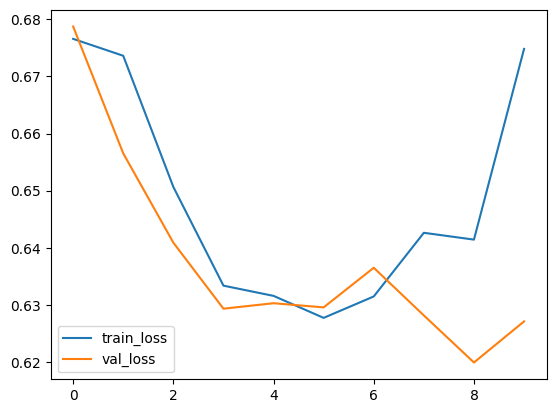

In [28]:
performances_df[['train_loss', 'val_loss']].plot()

<Axes: >

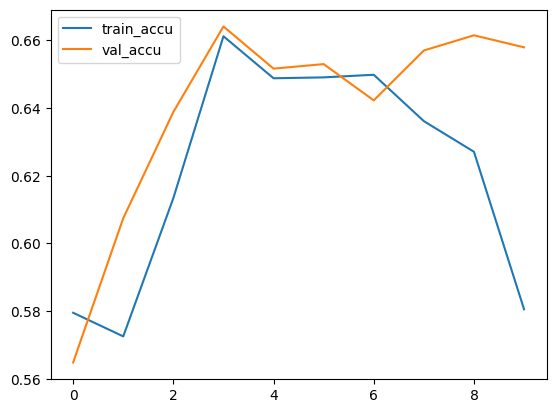

In [29]:
performances_df[['train_accu', 'val_accu']].plot()

<Axes: >

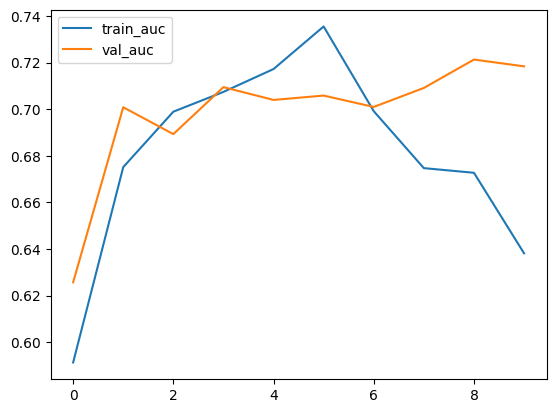

In [30]:
performances_df[['train_auc', 'val_auc']].plot()

# **CNN**

In [21]:
import torch.optim as optim

In [22]:
# Define the CNN model architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * (img_size[0] // 8) * (img_size[1] // 8), 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.pool3(x)
        x = x.view(-1, 128 * (img_size[0] // 8) * (img_size[1] // 8))
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize the model
model = CNN()

# Define the loss function, optimizer, and device
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the model
model.to(device)
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.float().unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validate the model
    model.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels.float().unsqueeze(1))
            valid_loss += loss.item()

            preds = torch.round(outputs)
            valid_acc += torch.sum(preds == labels.float().unsqueeze(1))

    # Print the loss and accuracy for each epoch
    print(f'Epoch {epoch+1} - Training Loss: {running_loss/len(train_loader):.4f} - Validation Loss: {valid_loss/len(valid_loader):.4f} - Validation Accuracy: {valid_acc/len(valid_dataset):.4f}')


Epoch 1 - Training Loss: 0.7038 - Validation Loss: 0.6749 - Validation Accuracy: 0.6512
Epoch 2 - Training Loss: 0.6745 - Validation Loss: 0.6553 - Validation Accuracy: 0.6395
Epoch 3 - Training Loss: 0.6631 - Validation Loss: 0.6758 - Validation Accuracy: 0.6163
Epoch 4 - Training Loss: 0.6750 - Validation Loss: 0.6590 - Validation Accuracy: 0.6744
Epoch 5 - Training Loss: 0.6820 - Validation Loss: 0.6528 - Validation Accuracy: 0.6628
Epoch 6 - Training Loss: 0.6642 - Validation Loss: 0.6393 - Validation Accuracy: 0.6628
Epoch 7 - Training Loss: 0.6587 - Validation Loss: 0.6313 - Validation Accuracy: 0.6163
Epoch 8 - Training Loss: 0.6512 - Validation Loss: 0.6182 - Validation Accuracy: 0.6163
Epoch 9 - Training Loss: 0.6421 - Validation Loss: 0.6107 - Validation Accuracy: 0.6628
Epoch 10 - Training Loss: 0.6545 - Validation Loss: 0.6174 - Validation Accuracy: 0.6279
Epoch 11 - Training Loss: 0.6246 - Validation Loss: 0.6441 - Validation Accuracy: 0.6744
Epoch 12 - Training Loss: 0.62